Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


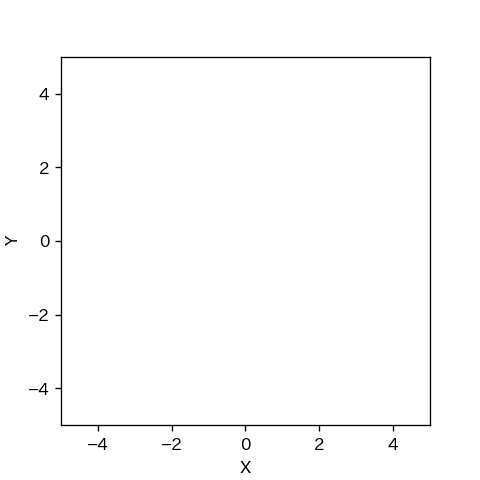

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [3]:
def trial_phantom_kidnap(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m,phantom_prob=0.1), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

In [4]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


0 真値: [ 4.06891283 -1.82070593  4.74578184] 推定値: [ 3.65968122 -4.99573642  3.32911324] 誤差: 3.2012949203092895
1 真値: [-1.61994497 -2.55533021  5.37983212] 推定値: [ 3.07635082  0.68370591 -2.70321416] 誤差: 5.704958298575661
2 真値: [-3.92820812 -2.25149174  4.32694371] 推定値: [ 2.49170335 -3.75033401  2.92885892] 誤差: 6.592555752853484
3 真値: [-1.4383265  -2.65846419  6.83233671] 推定値: [-0.72722147 -4.38892436  1.11560157] 誤差: 1.8708721945422537
4 真値: [3.82793898 0.84752434 4.7555569 ] 推定値: [-0.00114879  0.37895929 -0.57266821] 誤差: 3.857650360543045
5 真値: [-5.42196901  3.13567238  5.57707791] 推定値: [-5.74467009  1.26916785  0.28136232] 誤差: 1.8941951256876495
6 真値: [1.44689272 0.83966581 4.21092586] 推定値: [ 0.65946011  1.55516349 -1.90376344] 誤差: 1.0639487993999772
7 真値: [ 2.98205588 -3.30338227  7.29848345] 推定値: [0.28227315 3.20043841 3.10328989] 誤差: 7.041910973128593
8 真値: [-0.98313977  3.49804438  7.01439188] 推定値: [ 1.45276486  7.11727702 -0.23439194] 誤差: 4.362622640470317
9 真値: [3.44403242 0.1721

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-5.03770458 -1.75977804  6.11676412] 推定値: [ 0.67754086 -0.85246481 -1.23146866] 誤差: 5.786816719417458
21 真値: [ 3.94377736 -2.59823043  1.66135275] 推定値: [ 0.87359236 -3.18088516  0.98752388] 誤差: 3.124983604066335
22 真値: [2.44493578 0.27084897 8.35740259] 推定値: [4.69818929 0.47906347 2.83716876] 誤差: 2.2628532112382542
23 真値: [ 3.69898994 -1.17600108  2.99917115] 推定値: [ 3.06587123 -5.11768027  1.14776115] 誤差: 3.992201665926996
24 真値: [-3.05945039  3.83835432  6.32646511] 推定値: [-0.75098068  0.07172797  3.33400037] 誤差: 4.417749029073156
25 真値: [0.7203361  2.1921625  5.34931288] 推定値: [-2.42853139 -5.20234789  0.8761861 ] 誤差: 8.037048615268507
26 真値: [0.94143941 4.75673727 4.00251345] 推定値: [-1.21391481  6.25860488 -1.8362603 ] 誤差: 2.6270055420232064
27 真値: [ 3.03075478 -0.98826548  5.61617039] 推定値: [-4.54902736  1.17785896  1.41682809] 誤差: 7.883222206407468
28 真値: [ 2.44538819 -1.65168984  6.37703078] 推定値: [-3.58859691 -0.77084903  1.0162377 ] 誤差: 6.0979387312421816
29 真値: [-3.15901259